In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
# Keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential
from keras.regularizers import l2
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#Visualization
import matplotlib.cm as cm
from sklearn import random_projection

import datetime

In [2]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Measures':'category',
    'Quantity':'float32',
    'Total_Sales':'float32',
    'Value':'float32',
    'Week': 'int32',
    'Year':'int32'
}
original_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv'
processed_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_final_1.csv'
timeseries_path = r'D:\NOVAIMS_MAA\timeseries\product_total_ts.csv'

In [5]:
example = pd.read_csv(processed_path,dtype=dtype_dict,parse_dates=['Date'],nrows = 100,usecols = [1,2,3,4,5,6,7,8,9])
example.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Total_Sales
0,16,11,306,649,1970,1,2017-03-04,2.0,1540.0
1,16,11,306,649,1970,1,2016-05-02,4.0,3080.0
2,16,11,306,649,1970,1,2016-10-24,2.0,1540.0
3,16,11,306,649,1970,1,2017-10-13,2.0,1620.0
4,16,11,306,649,1970,1,2017-10-14,2.0,1620.0


In [6]:
df = pd.read_csv(timeseries_path,dtype=dtype_dict,usecols = [1,2,3,4,5])

In [7]:
df.head()

,Year,Month,Week,ProductName_ID,Quantity
0,2016,1,1,1000,766.0
1,2016,1,1,1004,727.0
2,2016,1,1,1006,491.0
3,2016,1,1,1007,636.0
4,2016,1,1,1013,1641.0


In [39]:
def preprocessing_month(dataframe,product_id):
    data = dataframe[dataframe['ProductName_ID'] == product_id]
    data = data.groupby(['Year','Month']).sum()['Quantity'].reset_index()
    data['Month'] =  data['Month'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
    data['TimeSeries'] = data['Year'].astype('string') + data['Month']
    #drop non-relevant columns
    data.drop(['Year','Month'], axis=1, inplace=True)
    data.set_index('TimeSeries',inplace=True)
    print("monthly timeseries generated")
    return data

def preprocessing_week(dataframe,product_id):
    data = dataframe[dataframe['ProductName_ID'] == product_id]
    data['Week'] =  data['Week'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
    data['TimeSeries'] = data['Year'].astype('string') + data['Week']
    #drop non-relevant columns
    data.drop(['Year','Month','Week','ProductName_ID'], axis=1, inplace=True)
    data.set_index('TimeSeries',inplace=True)
    print("weekly timeseries generated")
    return data

def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    dataset_val = dataset.values
    for i in range(interval, len(dataset)):
        value = dataset_val[i] - dataset_val[i - interval]
        diff.append(value[0])
    return pd.DataFrame({'diff':diff},index = dataset[1:].index)

def scale_func(df,size_split):
    len_df = df.shape[0]
    scaler = MinMaxScaler()
    scaler.fit(df.iloc[:int(len_df*size_split),:])
    scaled_data = scaler.transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

#create the training data set
def generate_input(df, window, out,size_split = 0.8):
    # df is the differencing dataframe
    #create the scaled training data set
    scaled_data, scaler = scale_func(df,size_split=size_split)
    #Split the data into x_train and y_train data sets
    len_df = scaled_data.shape[0]
    X = []
    Y = []
    for i in range(window, len(scaled_data)-window-out+1):
        x_train.append(scaled_data.iloc[i-window:i,:])
        y_train.append(scaled_data.iloc[i:(i+out),:])
    X, Y = np.array(X), np.array(Y)
    Y = Y.reshape(Y.shape[0], Y.shape[1])
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    train_size = int(len_df*size_split)
    x_train = X[:train_size]
    y_train = Y[:train_size]
    x_val = X[train_size:]
    y_val = Y[train_size:] 
    #y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))
    return x_train, y_train, x_val,y_val, scaled_data,scaler

def model_base_build(input_shape,output_len):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(100, return_sequences=False,  input_shape = input_shape))
    #model.add(LSTM(10, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(output_len))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_loss_histories(histories,names):
    rows = math.ceil(len(histories)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Training loss vs Validation Loss\n", fontsize=25)
    # Draw nested boxplots
    for history, name, ax in zip(histories, names , axes.flatten()):
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['train', 'validation'], loc='upper right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()
 # invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
# inverse data transform on forecasts
def inverse_transform(data, forecasts, scaler, x_val):
    inverted = list()
    out_put_len = 4
    for i in range(len(forecasts)): 
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(data) - len(x_val) + i - out_put_len
        last_ob = data.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = math.sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series,train_df, val_df, forecasts, n_test):
    plt.figure(figsize=(16,8))
    # plot the entire dataset in blue
    plt.plot(data.loc[train_df.index], label = "Train")
    plt.plot(val_df, label = "Validation")
	# plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 4
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
	# show the plot
    plt.xticks(rotation = 90)
    plt.show()  
    
def plot_series(data,figsize=(18,8)):
    plt.figure(figsize=figsize)
    plt.title('Quantity Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data)

In [71]:
# Check for top 10 products
df.groupby('ProductName_ID').sum()['Quantity'].sort_values(ascending = False)[:10]

ProductName_ID
1277    3170543.0
2609    3070767.0
481     2983412.0
993     2837871.0
1147    2801077.0
1234    2528432.0
2802    2521720.0
847     2447311.0
226     2437948.0
1422    2414555.0
Name: Quantity, dtype: float32

In [90]:
data = preprocessing_month(df,product_id='2609')

monthly timeseries generated


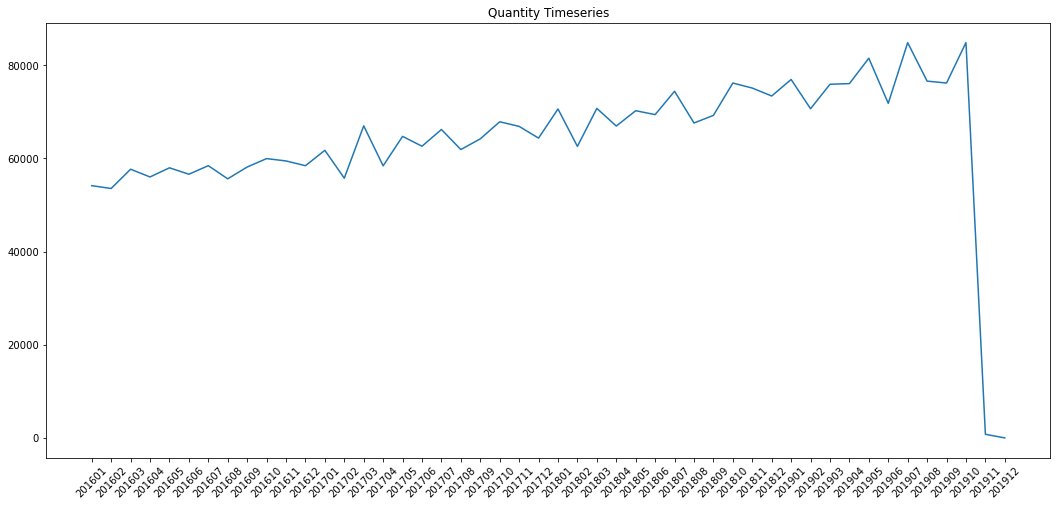

In [93]:
plot_series(data)

In [94]:
data.drop(index = ["201911","201912"],inplace = True)

In [95]:
n = data.shape[0]
train_df = data[0:int(n*.8)]
val_df = data[int(n*0.8):]

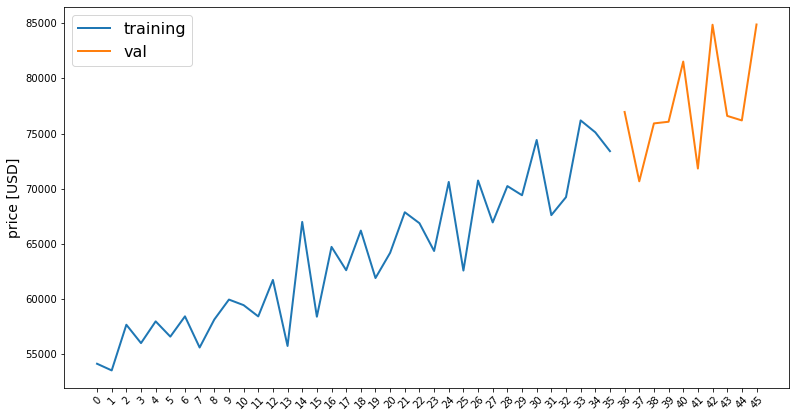

In [96]:
line_plot2(line1 = train_df, 
          line2 = val_df, label1='training',label2='val',title='')

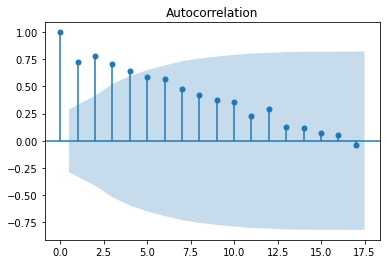

In [105]:
plot_acf(data)
plt.show()

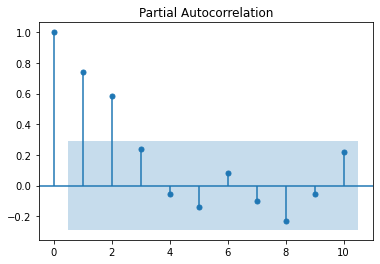

In [104]:
plot_pacf(data, lags=10)
plt.show()

In [106]:
dataset = difference(data)

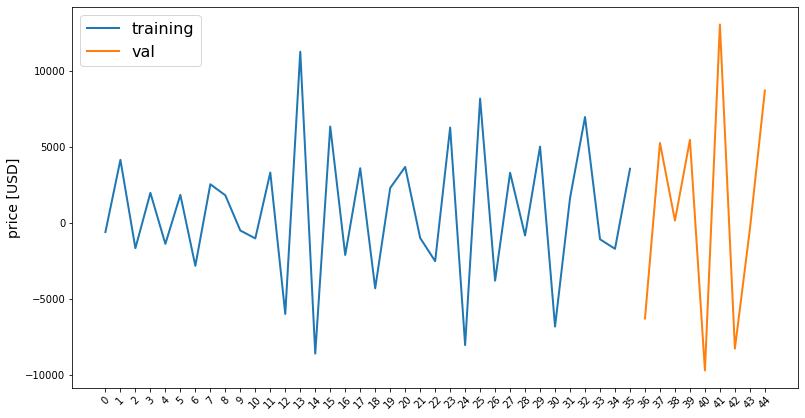

In [111]:
n = dataset.shape[0]
train_df = dataset[0:int(n*.8)]
val_df = dataset[int(n*0.8):]
line_plot2(line1 = train_df, 
          line2 = val_df, label1='training',label2='val',title='')

In [107]:
x_train, y_train, x_val, y_val, scaled_df, scaler = generate_input(dataset,window = 6, out = 3)

In [108]:
print(scaled_df.shape)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(45, 1)
(36, 6, 1)
(36, 3)
(1, 6, 1)
(1, 3)


In [56]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]),output_len=4)
history1 = LSTM1.fit(x_train, y_train, batch_size=1, epochs=1000    ,validation_data=(x_val,y_val))

0137
Epoch 812/1000
76/76 [==============================] - 0s 3ms/step - loss: 1.4702e-04 - val_loss: 0.0130
Epoch 813/1000
76/76 [==============================] - 0s 4ms/step - loss: 8.2882e-05 - val_loss: 0.0133
Epoch 814/1000
76/76 [==============================] - 0s 3ms/step - loss: 6.4344e-05 - val_loss: 0.0135
Epoch 815/1000
76/76 [==============================] - 0s 3ms/step - loss: 6.0705e-05 - val_loss: 0.0133
Epoch 816/1000
76/76 [==============================] - 0s 3ms/step - loss: 6.0910e-05 - val_loss: 0.0129
Epoch 817/1000
76/76 [==============================] - 0s 3ms/step - loss: 5.6988e-05 - val_loss: 0.0130
Epoch 818/1000
76/76 [==============================] - 0s 3ms/step - loss: 1.2755e-04 - val_loss: 0.0132
Epoch 819/1000
76/76 [==============================] - 0s 3ms/step - loss: 1.3547e-04 - val_loss: 0.0130
Epoch 820/1000
76/76 [==============================] - 0s 3ms/step - loss: 2.0312e-04 - val_loss: 0.0128
Epoch 821/1000
76/76 [===================

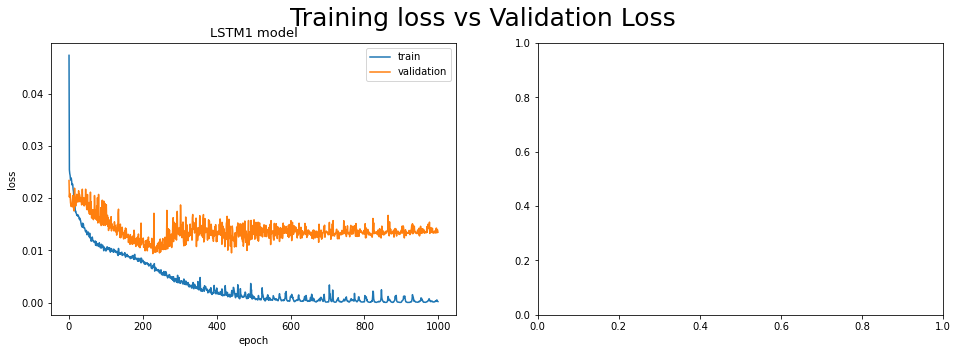

In [57]:
histories = [history1]
names = ['LSTM1']
plot_loss_histories(histories,names)

In [58]:
forecasts = LSTM1.predict(x_val)

In [59]:
forecasts

array([[0.4918884 , 0.27756044, 0.3798765 , 0.478191  ],
       [0.33139148, 0.32325476, 0.53376037, 0.4187734 ],
       [0.38177538, 0.67888826, 0.49987963, 0.537562  ],
       [0.52371335, 0.49980122, 0.50989807, 0.34378812],
       [0.7340057 , 0.29582548, 0.38432026, 0.425778  ],
       [0.2910022 , 0.4351875 , 0.49698472, 0.41941193],
       [0.301633  , 0.4371686 , 0.38061506, 0.60873103],
       [0.42974803, 0.3727428 , 0.4977476 , 0.35065544],
       [0.37866613, 0.6342493 , 0.2904802 , 0.4386225 ],
       [0.71299624, 0.3010373 , 0.37642455, 0.22709599]], dtype=float32)

In [61]:
evaluate_forecasts(y_val, forecasts, 6, 4)

t+1 RMSE: 0.160584
t+2 RMSE: 0.139339
t+3 RMSE: 0.069104
t+4 RMSE: 0.062522


In [62]:
y_predicted = inverse_transform(data,forecasts,scaler,x_val)

In [63]:
evaluate_forecasts(y_val, y_predicted, 6, 4)

t+1 RMSE: 18180.804518
t+2 RMSE: 17954.652246
t+3 RMSE: 17908.661701
t+4 RMSE: 17747.640482


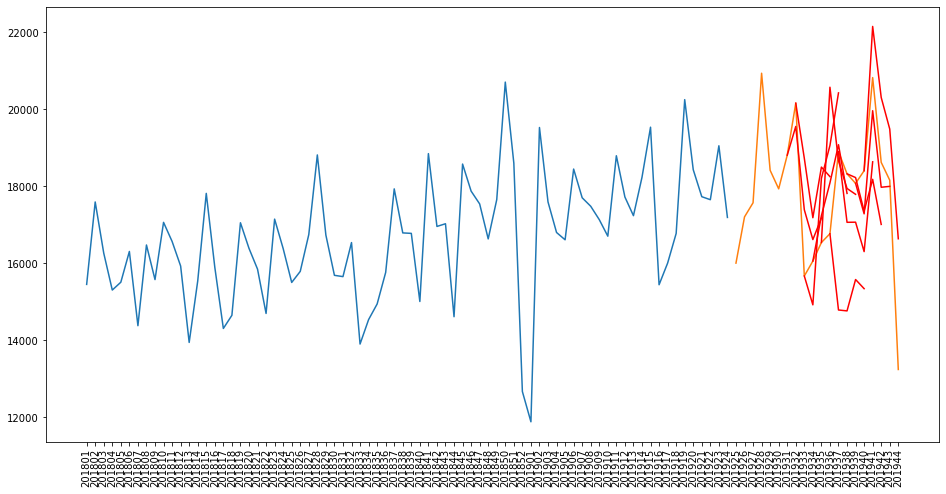

In [65]:
plot_forecasts(data,train_df,val_df,y_predicted,len(x_val))

## Weekly forecasting